In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
os.chdir("C:\\Users\\이혜림\\Desktop\\빅콘테스트/2020빅콘테스트 문제데이터(데이터분석분야-챔피언리그)/01_제공데이터")

# 한글 폰트 오류 해결
from matplotlib import font_manager, rc 
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" #폰트 파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)

In [240]:
# 제공 데이터
data = pd.read_csv("./실적데이터.csv") # 내부데이터 (19.01.01~19.12.31) 판매실적 데이터
"""
판매군 -> 무형인 것은 취급액 0 -> 제외 필요
"""
tv = pd.read_csv("./시청률데이터.csv") # 외부데이터(19.01.01~19.12.31) 시청률 데이터
all_app = pd.read_csv("./ns홈쇼핑_app.csv") # 외부데이터(19.01.01~20.05) 어플 사용 데이터
total = pd.read_csv("./정리데이터/휴일추가까지.csv")

# 평가데이터
submission = pd.read_csv("./평가데이터.csv") # 평가데이터 (2020.06) 판매실적 예측

In [241]:
submission

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 6:20,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
1,2020-06-01 6:40,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
2,2020-06-01 7:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,"59,800",NaN
3,2020-06-01 7:20,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
4,2020-06-01 7:40,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,"69,900",NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 0:20,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2887,2020-07-01 0:40,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2888,2020-07-01 1:00,20.0,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,-,NaN
2889,2020-07-01 1:20,20.0,100261,200875,아놀드파마 티셔츠레깅스세트,의류,"69,900",NaN


### 날씨 예보 데이터 EDA
- 칼럼
    - 강수확률
    - 강수량
    - 하늘상태
    - 최고, 최저기온
- 결과
    - 일 최대 예보 강수량이 높을 수록 주문량 증가 -> 실제 강수량 데이터에 비해 정확할 수도 있을 것 같음.
    - 일 평균 강수확률이 50% 이상일 때 유의미 -> 50% 이상, 50% 미만 0,1 로 범주화
    - 최고, 최저 기온 유의미 -> 수치형

- 향후 방향 : 실제 강수량과 예보 강수량 두 데이터를 모두 칼럼으로 사용하여 정확도 비교

In [503]:
# 날씨예보 데이터 읽어오기
fc_prop = pd.read_csv("./날씨예보/강수확률.csv")
fc_amount = pd.read_csv("./날씨예보/6시간 강수량.csv") 
fc_sky = pd.read_csv("./날씨예보/하늘상태.csv")
fc_top = pd.read_csv("./날씨예보/일최고기온.csv")
fc_bottom = pd.read_csv("./날씨예보/일최저기온.csv")
total = pd.read_csv("./정리데이터/휴일추가까지.csv")

forecast_data = {"강수확률":fc_prop, "강수량":fc_amount,"하늘상태":fc_sky, "일최고기온":fc_top, "일최저기온":fc_bottom} 


In [504]:
# 예보 데이터 프레임 생성
forecast = pd.DataFrame()

for name, data in forecast_data.items():
    amount_list=[]
    cycle = (data.shape[0])//365 # 하루 관측량
    for i in range(365):
        day_weather = data.iloc[i*cycle:(i+1)*cycle,-1].mean()
        amount_list.append(day_weather)
    forecast[name]=amount_list
                 
forecast["날짜"]=total["날짜"].unique()[:-1]  # 날짜 칼럼 추가

In [505]:
# 합쳐진 예보 데이터와 홈쇼핑 데이터 합침
total = total.merge(forecast, on="날짜")
total["월"]=pd.to_datetime(total["날짜"]).dt.month

In [506]:
def visual(col): # 범주 시각화 함수
    global a
    a = total.loc[(total["요일"]!=5)&(total["요일"]!=6),:] # 토,일 제외함으로써 요일성 제외
    a[f"범주_{col}"]=pd.cut(a[col],3) # 연속형 데이터를 범주형으로 변경
    sns.barplot(x=f"범주_{col}",y="주문량", data=a)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


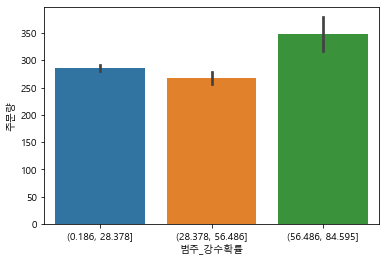

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


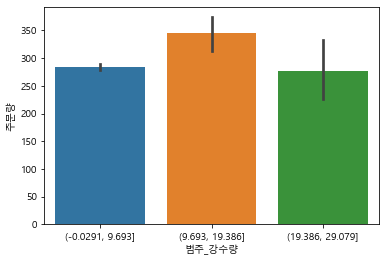

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


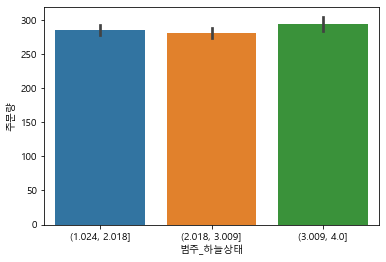

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


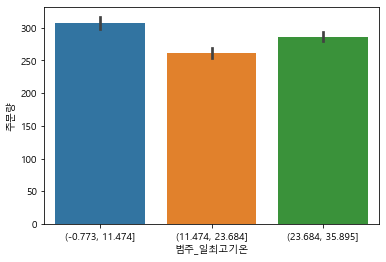

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


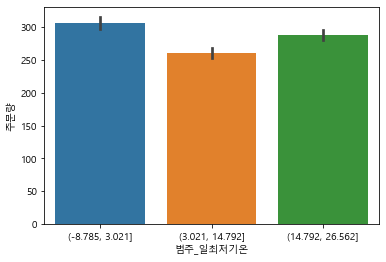

In [507]:
for name in forecast_data.keys():
    visual(name)

In [508]:
a

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,시간,...,시,주문량,holiday,강수확률,강수량,하늘상태,일최고기온,일최저기온,월,범주_일최저기온
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,2019-01-01,06:00:00,...,6,52.606516,1,1.148649,0.000000,1.114865,0.894737,-7.375,1,"(-8.785, 3.021]"
1,2019-01-01 06:00:00,0.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,2019-01-01,06:00:00,...,6,109.548872,1,1.148649,0.000000,1.114865,0.894737,-7.375,1,"(-8.785, 3.021]"
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,2019-01-01,06:20:00,...,6,81.754386,1,1.148649,0.000000,1.114865,0.894737,-7.375,1,"(-8.785, 3.021]"
3,2019-01-01 06:20:00,0.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,2019-01-01,06:20:00,...,6,174.310777,1,1.148649,0.000000,1.114865,0.894737,-7.375,1,"(-8.785, 3.021]"
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,2019-01-01,06:40:00,...,6,167.218045,1,1.148649,0.000000,1.114865,0.894737,-7.375,1,"(-8.785, 3.021]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38295,2019-12-31 23:20:00,0.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000,2019-12-31,23:20:00,...,23,11.243243,0,24.594595,0.039474,3.378378,1.684211,-6.000,12,"(-8.785, 3.021]"
38296,2019-12-31 23:40:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000,2019-12-31,23:40:00,...,23,51.398876,0,24.594595,0.039474,3.378378,1.684211,-6.000,12,"(-8.785, 3.021]"
38297,2019-12-31 23:40:00,0.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000,2019-12-31,23:40:00,...,23,90.964286,0,24.594595,0.039474,3.378378,1.684211,-6.000,12,"(-8.785, 3.021]"
38298,2019-12-31 23:40:00,0.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,2328000,2019-12-31,23:40:00,...,23,14.734177,0,24.594595,0.039474,3.378378,1.684211,-6.000,12,"(-8.785, 3.021]"
